Application of the Monte Carlo integration in Options trading (part I)
===========================================



$$\\[2pt]$$


Igor Marfin **[Unister Gmb@2014]** < <igor.marfin@unister.de>>


$$\\[40pt]$$


# Table of Contents

* &nbsp;
	* [0.1 Abstract](#1.1-Abstract)
	* [0.2 Initialization](#1.2-Initialization)
	* [0.3 Introduction](#1.3-Introduction)
		* [0.3.1 The Black–Scholes model of the option value](#1.3.1-The-Black–Scholes-model-of-the-option-value)
	* [0.4 Integration methods (schemes) for the stock prices](#0.4-Integration-methods-1.4-Integration-methods-%28schemes%29-for-the-stock-prices)
		* [0.4.1 Convergence of the Monte Carlo schemes](#1.4.1-Convergence-of-the-Monte-Carlo-schemes)
		* [0.4.2 Quantile of the distribution of stochastic variables](#1.4.2-Quantile-of-the-distribution-of-stochastic-variables)
	* [0.5 Machinery to operate the Option trading strategies](#1.5-Machinery-to-operate-the-Option-trading-strategies)
		* [0.5.1 Stock volatility](#1.5.1-Stock-volatility)
			* [0.5.1.1 Historical volatility calculator](#1.5.1.1-Historical-volatility-calculator)
			* [0.5.1.2 Instantaneous volatility calculator](#1.5.1.2-Instantaneous-volatility-calculator)
			* [0.5.1.3 Implied ( the future realized) volatility](#0.5.1.3-Implied-1.5.1.3-Implied-%28-the-future-realized%29-volatility)
		* [0.5.2 Monte Carlo calculation of the Option's Payoff](#1.5.2-Monte-Carlo-calculation-of-the-Option's-Payoff)
	* [0.6 Monte-Carlo Estimation of integrals](#1.6-Monte-Carlo-Estimation-of-integrals)
		* [0.6.1 Monte-Carlo Importance Sampling](#1.6.1-Monte-Carlo-Importance-Sampling)
			* [0.6.1.1 Reject/Accept method for the Monte-Carlo Importance Sampling](#1.6.1.1-Reject/Accept-method-for-the-Monte-Carlo-Importance-Sampling)
		* [0.6.2 Monte-Carlo with Stratified Sampling](#1.6.2-Monte-Carlo-with-Stratified-Sampling)

## 1.1 Abstract

--------------------------


Today I will start a series of tutorials on numerical methods useful in solving 
Stochastic Differential Equations (SDE). The stochastic differential equation is usually  governing the price evolution of a Option call or Option put. I am going to introduce you into the modeling the option tradings using python and Monte Carlo techniques.

Honestly saying, I got an idea to investigate the topic of the modeling  stochastic processes in the Finance a long time ago. Recently, I have bumped into a small pdf file 
<a name="ref-1"/>[(CamDavidson-Pilon, 2012)](#cite-Assignment) at the Cam Davidson-Pilon's github page  with an Assignment on the stochastic processes in Economics. And I have decided to understand and learn basic points given in the tasks. Therefore, I target two aims, first one is a step-by-step academical understanding of methods to work with stochastic processes in the Finance and second one is development of numerical methods to model stochastic processes in the stock/option tradings.


I have prepared the bitbucket repository  https://bitbucket.org/iggy_floyd/monte_carlo_stochastic_process, where I have placed these tutorials.

$$\\[5pt]$$

## 1.2 Initialization

________

To set up the python environment for the data analysis and make a nicer style of the notebook, one can run the following commands in the beginning of our modeling:

In [2]:
import sys
sys.path = ['/usr/local/lib/python2.7/dist-packages'] + sys.path # to fix the problem with numpy: this replaces  1.6 version by 1.9
%matplotlib inline
%pylab inline
ion()

import os
import matplotlib 
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import logging
import pymc as pm

# a plotter and dataframe modules
import seaborn as  sns # seaborn to make a nice plots of the data
import pandas as pd
import scipy.stats as stats
# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from book_format import load_style, figsize, set_figsize
load_style()



Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
%%javascript
IPython.load_extensions("calico-spell-check", "calico-document-tools",
"calico-cell-tools");


<IPython.core.display.Javascript object>

In [3]:
%%javascript
// to use latex environment, please install the plugin first:
// sudo ipython install-nbextension https://rawgit.com/jfbercher/latex_envs/master/latex_envs.zip
require("base/js/utils").load_extensions("latex_envs/latex_envs")

<IPython.core.display.Javascript object>

$$\\[5pt]$$

## 1.3 Introduction

------------------------------

A typical stochastic differential equation is of the form <a name="ref-2"/>[(Wiki:SDE, 2016)](#cite-Wiki)  


\begin{eqnarray}\label{def:SDE}
\mathrm{d} X_t = \mu(X_t,t)\, \mathrm{d} t + \sigma(X_t,t)\, \mathrm{d} B_t ,
\end{eqnarray}

$$\\[1pt]$$
where $X_t$ is a price of the asset (option),which follows to the stochastic process, $\mu(X_t,t)$ is a so-called trend function and $\sigma(X_t,t) \mathrm{d} B_t$ is a variation defined by the Wiener process $B_t$.

Before we go further and start a simple analysis, we want to understand the basics of the stochastic calculations. There is an important Itô's lemma <a name="ref-3"/>[(Wiki:Ito_Lemmma, 2016)](#cite-ITO), which is used in to find the differential of a time-dependent function of a stochastic process. This is an informal derivation of the lemma.

Assume $X_t$ is a Ito drift-diffusion process that satisfies the stochastic differential equation \ref{def:SDE}, where $\mu(X_t,t)=\mu_t$ and $\sigma(X_t,t) = \sigma_t$ functions are constans.  If f(t,x) is a twice-differentiable scalar function, its expansion in a Taylor series is


\begin{eqnarray}
df = \frac{\partial f}{\partial t}\,dt + \frac{\partial f}{\partial x}\,dx + \frac{1}{2}\frac{\partial^2 f}{\partial x^2}\,dx^2 + \cdots ,
\end{eqnarray}


\begin{eqnarray}
df = \frac{\partial f}{\partial t}\,dt + \frac{\partial f}{\partial x}(\mu_t\,dt + \sigma_t\,dB_t) + \frac{1}{2}\frac{\partial^2 f}{\partial x^2} \left (\mu_t^2\,dt^2 + 2\mu_t\sigma_t\,dt\,dB_t + \sigma_t^2\,dB_t^2 \right ) + \cdots. 
\end{eqnarray}


In the limit as $dt \rightarrow 0$, the terms $dt^2$ and $dtdBt$ tend to zero faster than $dB^2$, which is $O(dt)$. Setting them  to zero, substituting dt for $dB^2$, and collecting the $dt$ and $dB$ terms, we obtain



\begin{eqnarray}\label{def:ito}
df = \left(\frac{\partial f}{\partial t} + \mu_t\frac{\partial f}{\partial x} + \frac{\sigma_t^2}{2}\frac{\partial^2 f}{\partial x^2}\right)dt + \sigma_t\frac{\partial f}{\partial x}\,dB_t.
\end{eqnarray}


The equation \ref{def:ito} has an important meaning: the two-differential function of the stochastic process is also a stochastic process.



$$\\[5pt]$$

### 1.3.1 The Black–Scholes model of the option value

----------------------------------------------------


Itô's lemma is used to model the behavior of the option values. This model is called  the the Black–Scholes model for options. 

What is an option and what does the value of the option mean? To answer the questions,
I address you to the wiki page <a name="ref-4"/>[(Wiki:option, 2016)](#cite-Option) on the option trading.
The important term of the option trading is the value $V_t$ of the option. Basically, the value of the option is just the profit which would be obtained from selling the option at the moment of the expiry date, i.e.

\begin{eqnarray}
V_t = (S_t - C_t)\cdot N_s,
\end{eqnarray}

where $S_t$, $C_t$ and $N_s$ are  the stock price at the moment $t$ (before or at day of the expirity), the strike price and the number of the stock shares in the option.


Suppose a stock price follows a geometric Brownian motion given by the stochastic differential equation \cite{def:SDE}. Then, for the value of an option at time $t$ 
$V(t, S_t)$, Itô's lemma gives

\begin{eqnarray}
dV(t,S_t) = \left(\frac{\partial V}{\partial t} + \frac{1}{2}\left(S_t\sigma\right)^2\frac{\partial^2 V}{\partial S^2}\right)\,dt +\frac{\partial V}{\partial S}\,dS_t. 
\end{eqnarray}

This formula has a simple explanation:

Increase $dV(t,S_t)$ of the option value is proportional to the profit of having an amount $\frac{\partial V}{\partial S}$  of the stock with rising prise $S_t$ and increasing process behavior because of its stochastic nature. The last point is proportional to the magnitude of the volatility of the process. The larger variation the stock price shows, the more profit can be achieved by buying the option in the case when the tendency

$$ \frac{\partial^2 V}{\partial S^2} >0  $$

is fulfilled. If we buy the option, and our left cash held is assumed to grow at the risk free rate $r$, then the increase of the value $V_t$ at the time $t$ of our portfolio satisfies the following equation

\begin{eqnarray}
dV_t = r\left(V_t-\frac{\partial V}{\partial S}S_t\right)\,dt + \frac{\partial V}{\partial S}\,dS_t,
\end{eqnarray}
where the first term describes the profit we can obtain from putting our money into the risk-free investment fonds. Here I use the the notation of the option value $V_t$  for total portfolio value. The above formula of the total portfolio increase only makes a sense in the case when you have already bought the option.

Combining the two equations gives the celebrated Black–Scholes equation


\begin{eqnarray}\label{def:bs}
\frac{\partial V}{\partial t} + \frac{\sigma^2S^2}{2}\frac{\partial^2 V}{\partial S^2} + rS\frac{\partial V}{\partial S}-rV = 0. 
\end{eqnarray}


If we could integrate  \cite{def:bs} to predict the value of the option in the future time $t$, we would be able to minimize the risk by skipping from consideration such options which values will be predicted to be lowering.

$$\\[5pt]$$

## 1.4 Integration methods (schemes) for the stock prices

---------------------------------------------


To introduce integration techniques for solving different SDE like the  Black–Scholes model \cite{def:bs}, we start our study from solving the first tasks of the Cam Davidson-Pilson assignment <a name="ref-5"/>[(CamDavidson-Pilon, 2012)](#cite-Assignment).


> Consider the following class of interest rate models
>                                                           
>  dr_t = k(b − r_t )dt + sigma r_t^y dWt ,  t ≥ 0.
>
>  For your selection of the parameters r0 , k, b, sigma, and y (but y should be different >  from 1), use the Euler scheme, the Milstein scheme, and the second order approximation scheme to generate paths of this process.
>
>  (a) Using the three schemes to simulate paths, propose a Monte Carlo simulation method >  to  find q that satisfies
>  P{r3 > q} ≤ 0.1.
>  By considering the time step ∆ equal either to 0.004 or to 0.1, discuss accuracy 
>  of each method.

First we write a simple simulator of the stochastic process using Euler, Milstein and Runge-Kutta schemes.

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


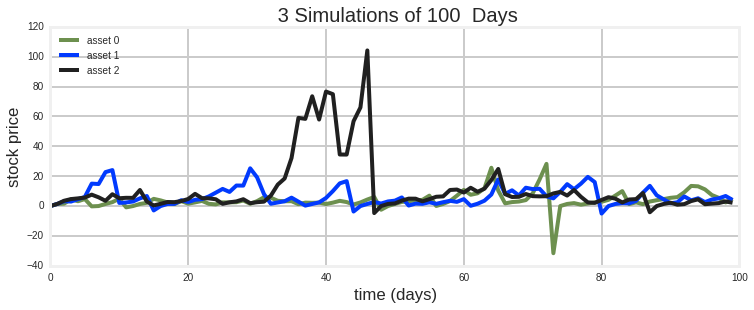

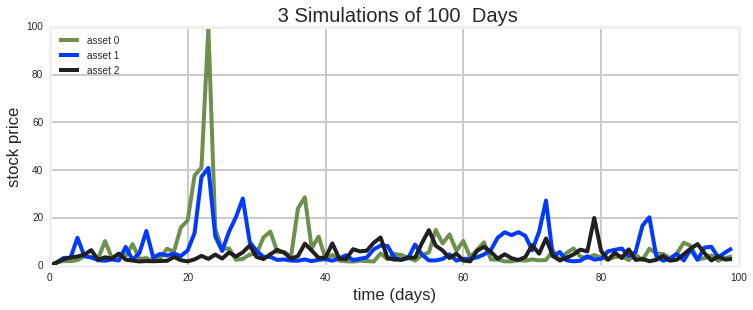

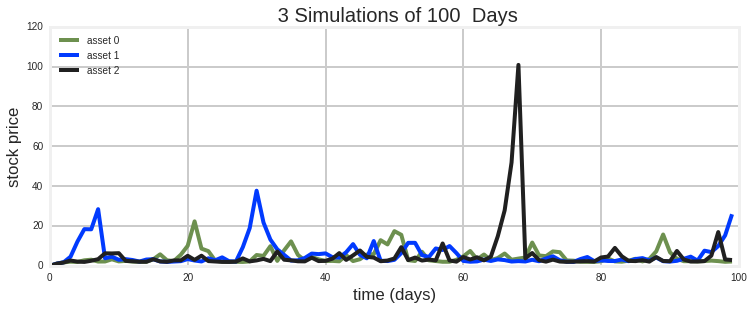

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:93: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


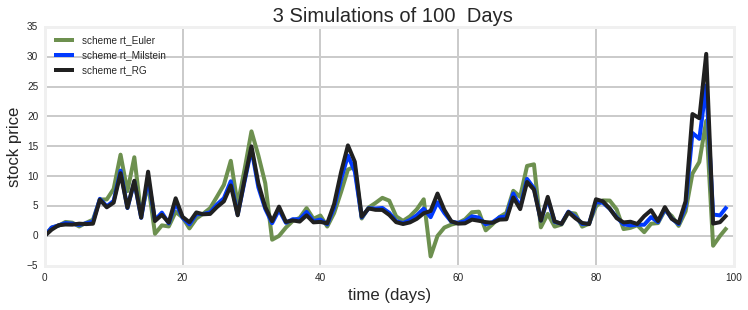

In [5]:
'''
   An example of the stochastic simulation
'''
from numpy.random import standard_normal
from numpy import array, zeros, sqrt, shape
from pylab import *
import numpy as np


# Let's consider this function
# dr_t = k(b − r_t )dt + sigma r_t^y dWt ,  t ≥ 0.
# It exactly matches to the Euler recurrent scheme

# our parameters
k=2e-1
b=7e0
sigma=5e-1
y=1.1


# an Euler Scheme

def rt_Euler(rt_prev,k,b,dt,sigma,y,dWt):
    ''' rate simulator: Euler scheme '''
    return rt_prev+k*(b-rt_prev)*dt + sigma*pow((rt_prev),y)*dWt

# a scheme functor depends on r, delta_t, delta_W
stochastic_Euler = lambda r,dt,dWt: rt_Euler(r,k,b,dt,sigma,y,dWt)

def Path(func,x_0=1e-9,T=100,dt=1e0, N_Sim=3):
    ''' generates the path of the stochastic process  using  schema '''
    
    
    Steps=round(T/dt); #Steps in years
    S = zeros([N_Sim, Steps], dtype=float)
    x = range(0, int(Steps), 1)

    for j in range(0, N_Sim, 1):
        S[j,0]= x_0
        for i in x[:-1]:            
            dWt=sqrt(dt)*standard_normal()
            val=func(S[j,i],dt,dWt)
            S[j,i+1]= x_0 if np.isnan(val) else val
        plot(x, S[j],label='asset %i'%j)
    title(' %d Simulations of %d  Days' % (int(N_Sim), int(Steps)))
    xlabel('time (days)')
    ylabel('stock price')
    legend(loc="upper left")
    show()    

Path(stochastic_Euler)       

# a Milstein Scheme
     
# Y_{n + 1} = Y_n + a(Y_n) \Delta t + b(Y_n) \Delta W_n +
# \frac{1}{2} b(Y_n) b'(Y_n) \left( (\Delta W_n)^2 - \Delta t \right), 

def afunc(rt_prev,k,b):
    return k*(b-rt_prev)
def bfunc(rt_prev,sigma,y):
    return sigma*pow((rt_prev),y)
def bfuncprime(rt_prev,sigma,y):
    return sigma*y*pow((rt_prev),y-1)

    
def rt_Milstein(rt_prev,k,b,dt,sigma,y,dWt):
    ''' rate simulator: Milstein scheme '''
    return rt_prev+afunc(rt_prev,k,b)*dt +bfunc(rt_prev,sigma,y)*dWt+0.5*bfunc(rt_prev,sigma,y)*bfuncprime(rt_prev,sigma,y)*(dWt*dWt - dt)

stochastic_Milstein = lambda r,dt,dWt: rt_Milstein(r,k,b,dt,sigma,y,dWt)

Path(stochastic_Milstein)    


# Runge–Kutta method or the second order approximation scheme 
def rt_Middle(rt_prev,k,b,dt,sigma,y):
    return rt_prev + afunc(rt_prev,k,b)*dt +bfunc(rt_prev,sigma,y)*pow(dt,0.5)

def rt_RG(rt_prev,k,b,dt,sigma,y,dWt):
    _rt = rt_Middle(rt_prev,k,b,dt,sigma,y)
    return rt_prev+afunc(rt_prev,k,b)*dt +bfunc(rt_prev,sigma,y)*dWt+0.5*(bfunc(_rt,sigma,y)-bfunc(rt_prev,sigma,y))*(dWt*dWt - dt)*pow(dt,-0.5)

stochastic_RG = lambda r,dt,dWt: rt_RG(r,k,b,dt,sigma,y,dWt)

Path(stochastic_RG)    

def PathComparison(funcs,x_0=1e-9,T=100,dt=1e0):
    ''' generates the path of the stochastic process  using  schema '''
    
    
    Steps=round(T/dt); #Steps in years
    N_Sim = len(funcs)
    S = zeros([N_Sim, Steps], dtype=float)
    x = range(0, int(Steps), 1)
    for j in range(0, N_Sim, 1):
        S[j,0]= x_0
    for i in x[:-1]:                    
        dWt=sqrt(dt)*standard_normal()
        for j in range(0, N_Sim, 1):                                    
            val=funcs[j](S[j,i],dt,dWt)
            S[j,i+1]= x_0 if np.isnan(val) else val
    for j in range(0, N_Sim, 1):              
        plot(x, S[j],label='scheme %s'%funcs[j].func_code.co_names[0])
    title(' %d Simulations of %d  Days' % (int(N_Sim), int(Steps)))
    xlabel('time (days)')
    ylabel('stock price')
    legend(loc="upper left")
    show()    

PathComparison([stochastic_Euler,stochastic_Milstein,stochastic_RG])

Our generators look good.

### 1.4.1 Convergence of the Monte Carlo schemes

------------------------------------------------

How good is the convergence of each scheme? To answer this question, I will use a method proposed in this lecture <a name="ref-6"/>[(JanPalcyewski, 2016)](#cite-NumericalSchemes).

In [6]:
'''
    Estimation of the Convergence for different schemes of SDE simulations
'''

def X_t_dt(t_n,dt,X_n,X_n_1):
    t=np.random.uniform(t_n,dt)
    return X_n + (t-t_n)*(X_n_1-X_n)/dt

def PathForConvergenceHighPrec(func,x_0=1e-9,T=100,dt=1e0,N_Sim=300):
    ''' generates the path of the stochastic process  using  some schema with High Precision '''
    
    
    Steps=round(T/dt); #Steps in years    
    S = zeros([N_Sim, Steps], dtype=float)
    x = range(0, int(Steps), 1)

    for j in range(0, N_Sim, 1):
        S[j,0]= x_0
        for i in x[:-1]:            
            dWt=sqrt(dt)*standard_normal()
            val=func(S[j,i],dt,dWt)
            S[j,i+1]= x_0 if np.isnan(val) else val
    mean=np.mean(S,axis=0)
    ts=np.empty(Steps)
    ts.fill(dt)
    return mean,np.cumsum(ts)

path_high_prec,x=PathForConvergenceHighPrec(stochastic_Euler,dt=1e-3)


def ReplicatePathShape(path1,path2):
    return np.repeat(path1,path2.shape[0]/path1.shape[0])


def PathToTestConvergence(func,x_0=1e-9,T=100,dt=1e0, N_Sim=300):
    ''' generates the path of the stochastic process  using some schema '''
    
    
    Steps=round(T/dt); #Steps in years
    S = zeros([N_Sim, Steps], dtype=float)
    x = range(0, int(Steps), 1)

    for j in range(0, N_Sim, 1):
        S[j,0]= x_0
        for i in x[:-1]:            
            dWt=sqrt(dt)*standard_normal()
            val=func(S[j,i],dt,dWt)
            S[j,i+1]= x_0 if np.isnan(val) else val
    mean=np.mean(S,axis=0)
    return mean


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Then I define the estimator of the strong convergence as it was supposed in the lecture.
Also I illustrate the convergence  of the Euler scheme and estimate the convergence limit parameters.

A Convergence limit obtained from a random path:  1.57*deltaT^0.21
A Convergence limit obtained from an ensemble of paths:  2.42*deltaT^0.78


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


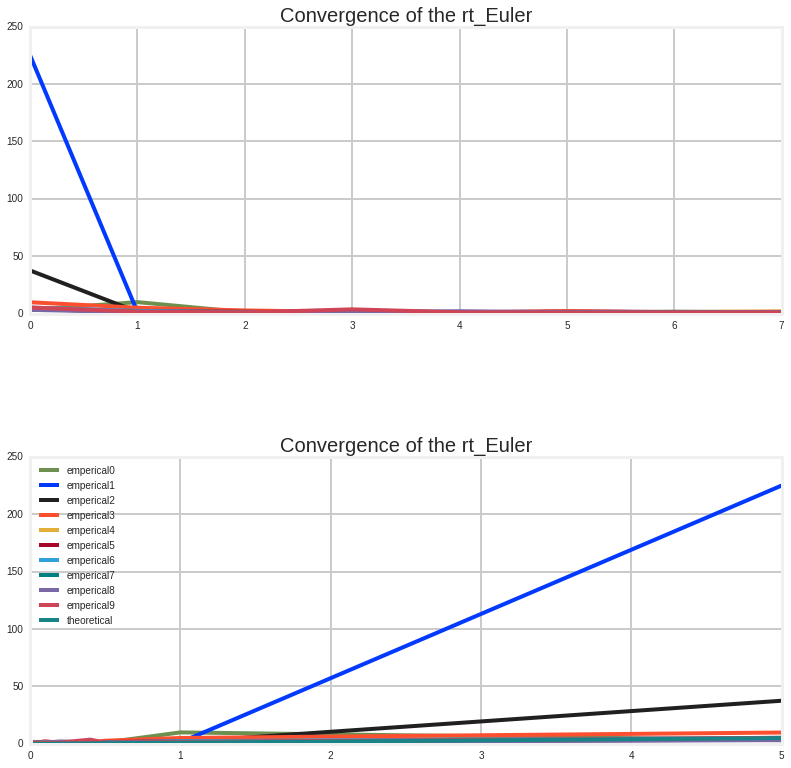

In [12]:
def ConvergenceStrong(func,dt,path_ref,N_Sim=100):
    path=PathToTestConvergence(func,dt=dt,N_Sim=N_Sim)
    path = ReplicatePathShape(path,path_ref)
    return np.mean(np.absolute(path-path_ref))
    
deltaT =[5e0,1e0,5e-1,4e-1,2e-1,1e-1,5e-2,2e-2]
def ConvergenceStrongSeries(func,path_ref,deltaT):
    return [ ConvergenceStrong(func,dt,path_ref) for dt in deltaT ]
#    for dt in deltaT:
#        yield ConvergenceStrong(func,dt,path_ref)

# to produce some ensemble of the different convergences 
how_many=10
ConvergenceStrongSeriesMany = [ConvergenceStrongSeries(stochastic_Euler,path_high_prec,deltaT) for i in range(how_many)]
ConvergenceSeries =ConvergenceStrongSeries(stochastic_Euler,path_high_prec,deltaT)
scheme=stochastic_Euler.func_code.co_names[0]
def plotConvergengeSingle(deltaT,ConvergenceSeries,scheme):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    # a first plot: improving convergence with descreasing deltaT
    ax1.plot(range(len(deltaT)),ConvergenceSeries)
    ax1.set_title("Convergence of the %s"% scheme)
    # a second plot: convergence as a function of the deltaT
    ax2.plot(deltaT,ConvergenceSeries,label='emperical')
    ax2.plot(deltaT,deltaT,label='theoretical')
    ax2.set_title("Convergence of the %s"%scheme)
    ax2.legend(loc="upper left")
    show()    

def plotConvergengeMultiple(deltaT,ConvergenceStrongSeriesMany,scheme):
    ''' it is as plotConvergengeSingle but it plots multiple stochastic series of the 
        convergencies
    '''
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    for ConvergenceSeries in ConvergenceStrongSeriesMany:
        ax1.plot(range(len(deltaT)),ConvergenceSeries)
    ax1.set_title("Convergence of the %s"% scheme)
    #
    for i,ConvergenceSeries in enumerate(ConvergenceStrongSeriesMany):
        ax2.plot(deltaT,ConvergenceSeries,label='emperical%d'%i)
    ax2.plot(deltaT,deltaT,label='theoretical')
    ax2.set_title("Convergence of the %s"%scheme)
    ax2.legend(loc="upper left")
    show()      
    
from scipy import optimize
def findConvergenceParams(deltaT,ConvergenceSeries):    
    # fit our result to find convergence parameters
    # method 1
    #fitfunc = lambda p, x: p[0]*pow(x,p[1])# Target function
    #errfunc = lambda p, x, y: fitfunc(p, x) - y # Distance to the target function
    #p0 = [1., 1.] # Initial guess for the parameters
    #p1, success = optimize.leastsq(errfunc, p0[:], args=(np.array(deltaT), np.array(ConvergenceSeries)))

    # method 2
    def f(x,a,b): return a*pow(x,b)    
    p1=optimize.curve_fit(f, np.array(deltaT), np.array(ConvergenceSeries))[0]
    return p1

def findConvergenceParamsFromMany(deltaT,ConvergenceStrongSeriesMany):
    ''' fit parameters of the convergence limits from several stochastic series
        and return the average values of the parameters    
    '''
    res=[]
    for ConvergenceSeries in ConvergenceStrongSeriesMany:        
        res+=[findConvergenceParams(deltaT,ConvergenceSeries)]
    #print res
    return np.mean(np.array(res),axis=0).tolist()

p1=findConvergenceParams(deltaT,ConvergenceSeries)
p2=findConvergenceParamsFromMany(deltaT,ConvergenceStrongSeriesMany)
#print p2
print "A Convergence limit obtained from a random path:  {0:.2f}*deltaT^{1:.2f}".format(*p1)
print "A Convergence limit obtained from an ensemble of paths:  {0:.2f}*deltaT^{1:.2f}".format(*p2)

plotConvergengeMultiple(deltaT,ConvergenceStrongSeriesMany,scheme)

From previous estimations, we get that the strong convergence for the Euler scheme is about $$\lim_{\delta \to 0}E(|S_t^T - S_t^{Euler}|)\sim 1.79*{\delta t}^{0.45},$$ where $S_t^T$ is an exact solution of the SDE.

### 1.4.2 Quantile of the distribution of stochastic variables

------------------------------------------------------------


Let's try to answer the question (a): 
>  (a) Using the three schemes to simulate paths, propose a Monte Carlo simulation method >  to  find q that satisfies
>  P{r3 > q} ≤ 0.1.

Method #1: Pr(r3>3.47)<=0.1
Method #2: Pr(r3>3.46)<=0.1


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


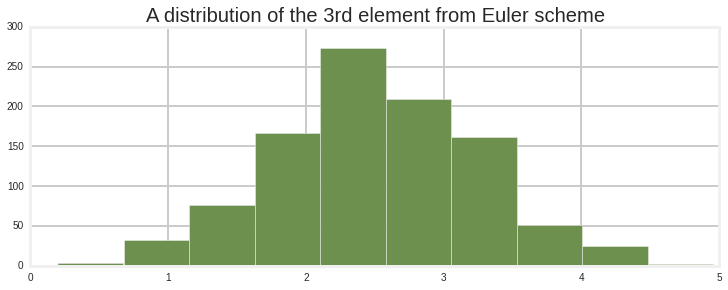

In [13]:
def PathGenerator(func,x_0=1e-9,T=100,dt=1e0, N_Sim=1000):
    ''' generates the path of the stochastic process  using some schema '''
    
    
    Steps=round(T/dt); #Steps in years
    S = zeros([N_Sim, Steps], dtype=float)
    x = range(0, int(Steps), 1)

    for j in range(0, N_Sim, 1):
        S[j,0]= x_0
        for i in x[:-1]:            
            dWt=sqrt(dt)*standard_normal()
            val=func(S[j,i],dt,dWt)
            S[j,i+1]= x_0 if np.isnan(val) else val    
    return  S
distr3elem=PathGenerator(stochastic_Euler)[:,2]


hist(distr3elem) # get a r3 distributions (3rd step of the monte carlo simulation)
title("A distribution of the 3rd element from Euler scheme")


# calculate the quantile of 0.1
quantile=0.1
# method 1
from scipy.stats.mstats import mquantiles
print "Method #1: Pr(r3>{0:.2f})<=0.1".format(*mquantiles(distr3elem,prob=[1.-quantile]))

# method 2 using the normal approximation
import scipy
mean=np.mean(distr3elem)
var=np.std(distr3elem)
print "Method #2: Pr(r3>{0:.2f})<=0.1".format(*scipy.stats.norm.ppf( [1.-quantile], mean, var))



Here I repeat all previous exercises for the Milstein scheme.

In [14]:
# let's get our theoretical solution of the stochastic differential equation :-)
path_high_prec,x=PathForConvergenceHighPrec(stochastic_Milstein,dt=1e-3)

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [15]:
# now produce a set of the convergence series
ConvergenceStrongSeriesMany = [ConvergenceStrongSeries(stochastic_Milstein,path_high_prec,deltaT) for i in range(how_many)]
ConvergenceSeries =ConvergenceStrongSeries(stochastic_Milstein,path_high_prec,deltaT)
scheme=stochastic_Milstein.func_code.co_names[0]


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [16]:
# here we find parameters of the convergence limit
p1=findConvergenceParams(deltaT,ConvergenceSeries)
p2=findConvergenceParamsFromMany(deltaT,ConvergenceStrongSeriesMany)


A Convergence limit obtained from a random path:  1.48*deltaT^2.30
A Convergence limit obtained from an ensemble of paths:  1.74*deltaT^1.06


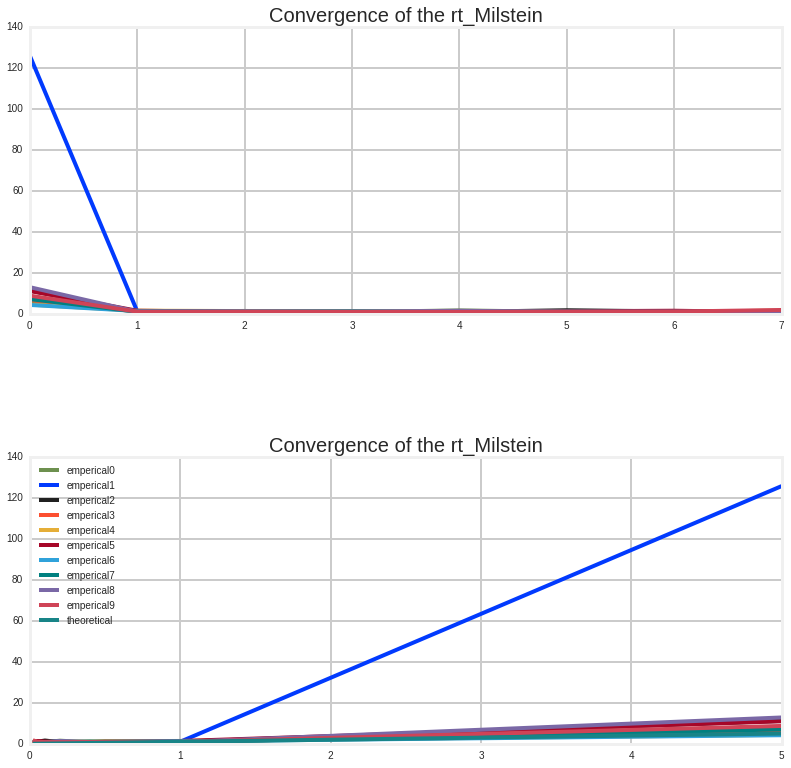

In [17]:
# plot obtained results
print "A Convergence limit obtained from a random path:  {0:.2f}*deltaT^{1:.2f}".format(*p1)
print "A Convergence limit obtained from an ensemble of paths:  {0:.2f}*deltaT^{1:.2f}".format(*p2)

plotConvergengeMultiple(deltaT,ConvergenceStrongSeriesMany,scheme)

Method #1: Pr(r3>3.54)<=0.1


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


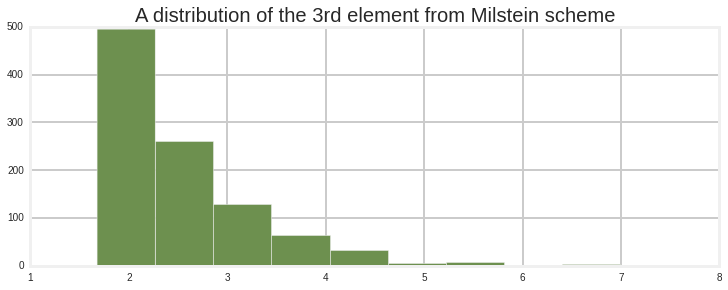

In [18]:
# a quantile study
distr3elem=PathGenerator(stochastic_Milstein)[:,2]
hist(distr3elem) # get a r3 distributions (3rd step of the monte carlo simulation)
title("A distribution of the 3rd element from Milstein scheme")

print "Method #1: Pr(r3>{0:.2f})<=0.1".format(*mquantiles(distr3elem,prob=[1.-quantile]))



Here is a summary on the obtained results for the Milstein scheme

  1. the strong convergence  is about $$\lim_{\delta \to 0}E(|S_t^T - S_t^{Milstein}|)\sim 1.74*{\delta t}^{1.06} $$
  2. Pr(r3>3.60)<=0.1

$$\\[5pt]$$

## 1.5 Machinery to operate the Option trading strategies

------------------------------------------

Now it is a time when we can introduce a few useful terms needed to understand what the  European vanilla option is. From the wiki about Options <a name="ref-7"/>[(Wiki:option, 2016)](#cite-Option), 
we can conclude that

1.  an option is a contract which gives the buyer (the owner or holder of the option) the right, but not the obligation, to buy or sell an underlying asset or instrument at a specified strike price on or before a specified date;

2. there are the Call Option, which is a contract to buy stock shares and the Put Option,
which guarantees you to sell stocks at the strike price.


We restrict ourselves to consideration of the **Call Options**. Call Options have the following properties (I have just copied-pasted the wiki text here):


1. **Strike price**: this is the price at which you can buy the stock (if you have bought a call option) or the price at which you must sell your stock (if you have sold a call option).
2. **Expiry date**: this is the date on which the option expires, or becomes worthless, if the buyer doesn't exercise it.
3. **Premium**: this is the price you pay when you buy an option and the price you receive when you sell an option.

The current price of the Call Option on the market $S_t^{Option}$  is defined by the formula


\begin{eqnarray}\label{def:priceOptionCall}
S_t^{Option} = S_t^{stock} + Premium - S^{Strike},
\end{eqnarray}

$$\\[1pt]$$

where   $S_t^{stock}$ is the current stock price, $Premium$ is the price you have to pay to the option holder because of the volatility of the stock prices.

The call premium tends to go down as the option gets closer to the call date. And it goes down as the option price rises relative to the stock price. 
Also it is worth to mention that there are Bid/Ask prices of the option which are
is more relevant in ascertaining the value of the option than the last price since options are not frequently traded. **Meaning the value is usually the Ask/Bid Price**. I want to clarify the Bid/Ask price definitions a little bit. As Investopedia <a name="ref-8"/>[(Investopedia, 2016)](#cite-BidAskSpread) states, the Bid/Ask/Spread terms on the market are fully determined by the concept of the **Supply and Demand**.

> **Supply** refers to the **volume** or abundance of a particular item in the marketplace, such as the supply of stock for sale. 
> **Demand** refers to an individual's willingness to pay a particular **price** for an item or stock. 

>Suppose that a one-of-a-kind diamond is found in the remote countryside of Africa by a miner.  Two potential buyers make themselves known about the diamond and submit bids for \$1.2 million and \$1.3 million dollars (**the Bid prices**), respectively. The asking (**Ask**) price of that diamond will be \$1.3 million dollars more likely.

>The spread is the difference between the bid and asking prices for a particular security.





**An option usually covers 100 shares. So the bid/ask price should be multiplied by 100 to get the total cost**.

Let`s consider a realistic example for trading option strategy from the wiki:

>Let's say we bought 3 PNC strike \$45, January 2012 call options in August for \$11.75. That means we paid \$3,525 (11.75 \* 3 options for 100 shares each) for the right to buy 300 (3\*100) PNC shares for \$45 per share between now and January 2012.

>The stock at that time traded at \$50.65 meaning the theoretical call premium was \$6.1 as shown by our formula: (current price + theoretical time/volatility premium) – strike price, (50.65 + 6.1 – 45 = 11.75).

>Today the stock is trading at \$64 making the call option worth \$19.45 with a theoretical call premium now of 45 cents above its in-the-money intrinsic value \$19 (the \$64 market price minus the call option \$45 strike price).

First, we want to develop a simple scrambler to get data from Yahoo Finance. The pandas framework has
an experimental tool ``pandas.io.data.Options`` which directly operates with Yahoo Finance!. This tool requires
``lxml`` library to be installed in the system. To install lxml support for the python in the  ``Debian``, we can ``apt-get`` like it is shown below:

``sudo apt-get install python-lxml``

In [19]:
"""
    A simple Scrapper of the Option data
"""
from pandas.io.data import Options
import datetime

def get_option_data(ticker,exp_date,strike_price_slice,type="call"):
    """
        return call and put options
    """
    x = Options(ticker,'yahoo')
    index=(strike_price_slice,slice(None),type)
    return x.get_options_data(expiry=exp_date).loc[index,:]


# our test parameters of the option market
# I want to get information on options with 

# 1) expiry--> 1st October of 2016
expiry = datetime.date(2016, 10, 1)
# 2) stock name (underlying)
ticker='aapl'
# 3) slice on the strike price
strike_price_slice=slice(100.,110.,1)
# 4) type of the option: 'call'
option_type = "call"
options_data=get_option_data(ticker,expiry,strike_price_slice,option_type)

options_data

,,,,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time
Strike,Expiry,Type,Symbol,,,,,,,,,,,,,
100,2016-10-21,call,AAPL161021C00100000,14.95,14.85,15.00,-0.31,-2.03%,65,11208,25.91%,AAPL,False,AAPL,111.58,2016-04-14 10:25:00
105,2016-10-21,call,AAPL161021C00105000,11.55,11.45,11.55,-0.25,-2.12%,18,7428,25.07%,AAPL,False,AAPL,111.58,2016-04-14 10:25:00
110,2016-10-21,call,AAPL161021C00110000,8.60,8.55,8.65,-0.28,-3.15%,183,13655,24.52%,AAPL,False,AAPL,111.58,2016-04-14 10:25:00


OK. What can be done else? We will need to have a calculator of the stock volatility.

$$\\[5pt]$$

### 1.5.1 Stock volatility

------------------------------------------

There are many definitions of the Stock Volatility. I will try to undercover all of the them.

First, let's recover the difinion of the stock return. Suppose $S_t$ is the price of the stock on day $t$, then the daily return on day $t$ is:


\begin{eqnarray}\label{def:return}
r_t = \frac{ S_t - S_{t-1} }{ S_{t-1} }.
\end{eqnarray}

$$\\[1pt]$$


Also logarithmic returns are defined according to the Financial Mathematics
<a name="ref-9"/>[(WikiVolatility, 2016)](#cite-WikiVolatility).
The logarithmic returns are determined as follows


\begin{eqnarray}\label{def:logreturn}
logr_t = log(r_t+1).
\end{eqnarray}

$$\\[1pt]$$

Let's implement the calculation of returns for stocks. I will copy/paste a few code from my previous study **"Money Management System: Portfolio Optimization Approaches or How to Become a Millionaire from stock tradings"**.

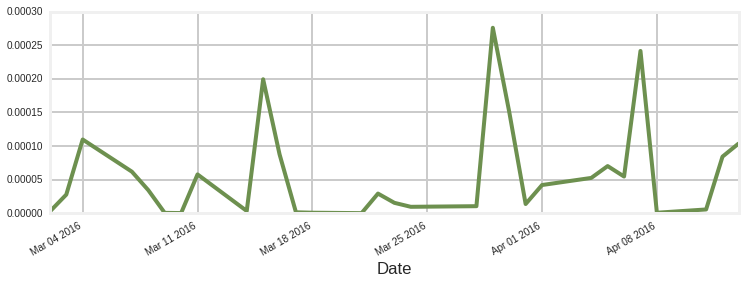

In [20]:
'''
    Igor Marfin <Unister Gmb, 2014> igor.marfin@unister.de    
    
    Extraction the financial data from Yahoo! Finance
    
    Returns calculation
    
'''


from pandas.io.data import DataReader   
from datetime import datetime

instruments=['AAPL']


def getStockPrices(startdate=datetime(2016,3,1),enddate=datetime.now(),stocks =instruments):              
    '''returns the stock prices'''
    data= map(lambda x: DataReader(x,  "yahoo", startdate,enddate),stocks)
    for i,symbol in enumerate(stocks):
        data[i]['Symbol'] = stocks[i]
    return data


def addReturns(dataframe,price='Close'):
    '''adds the returns on the price'''
    
    # get Series on the interested column
    _series = dataframe[price]
    _series = _series.pct_change()
    dataframe[price+'_return'] = _series    
    return dataframe

def addLogReturns(dataframe,price='Close'):
    '''adds the logarithmic returns on the price'''
    
    # get Series on the interested column    
    _series = dataframe[price]
    _series = _series.pct_change()    
    _series =_series.apply(lambda x: np.log(x+1))        
    dataframe[price+'_logreturn'] = _series
    return dataframe

# test of the reader and 'PctChange' adder
data=getStockPrices() 
index=0 # get data of the 1st instrument

# check the difference between two definitions
pd.Series(addLogReturns(addReturns(data[index])).dropna()["Close_return"] -
          addLogReturns(addReturns(data[index])).dropna()["Close_logreturn"]).plot()

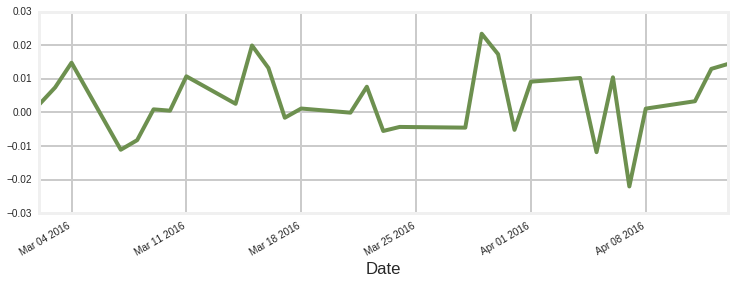

In [21]:
# a plot of the logarithmic returns
addLogReturns(addReturns(data[index])).dropna()["Close_logreturn"].plot()

So, the difference in results is marginal. 

$$\\[5pt]$$

#### 1.5.1.1 Historical volatility calculator

-------------------------------------

$$\\[5pt]$$

Let's add several calculators of the stock volatility.

In [22]:
'''
    Igor Marfin <Unister Gmb, 2014> igor.marfin@unister.de    
    
   Volatility calculators
    
'''

def VolatilityPriceStdDev(dataframe,price='Close'):
    '''
     It returns Std Deviation of the price as its Volatility.
     More details can be found here
         http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:standard_deviation_volatility
    '''
    #print dataframe[price].describe()
    return dataframe[price].std()

# test of the Std Deviation for price
print 'Std Deviation for the Close price ',VolatilityPriceStdDev(data[index])


def VolatilityReturnsStdDev(dataframe,price='Close',type="return"):
    '''
        calculate returns of the prices. More details
        https://gist.github.com/johntyree/4587049
        http://www.arngarden.com/2013/06/02/calculating-volatility-of-multi-asset-portfolio-example-using-python/
    '''     
    return dataframe[price+'_'+type].std()

# test of the Std Deviation for returns
print 'Std Deviation for the return ',VolatilityReturnsStdDev(data[index])
print 'Std Deviation for the logarithmic return ',VolatilityReturnsStdDev(data[index],type="logreturn")


'''
 Realizations of the Volatility given at https://en.wikipedia.org/wiki/Volatility_%28finance%29
 They relates to so-called "actual historical volatility"

'''
import math
import datetime
def annualized_historical_volatility(past_rollback_in_days=30,stocks =instruments):
    '''
        returns the annualized volatility
        https://gist.github.com/johntyree/4587049
    '''
    enddate=datetime.datetime.now()
    startdate=enddate-datetime.timedelta(days=past_rollback_in_days)
    data = getStockPrices(startdate=startdate,enddate=enddate,stocks =stocks)
    data = [ addLogReturns(addReturns(data[i]))  for i,elem in enumerate(data)]
    return [ math.sqrt(252.)*VolatilityReturnsStdDev(elem,price='Close',type="logreturn")  for _,elem in enumerate(data)]


print 'Historical annualized volatility for last 30 days ', annualized_historical_volatility()
print 'Historical annualized volatility for last 60 days ', annualized_historical_volatility(past_rollback_in_days=60)

def historical_volatility(period_fraction,past_rollback_in_days=30,stocks =instruments):
    '''
        return a generalized volatility for some period: day,monthly
    '''
    vol = annualized_historical_volatility(past_rollback_in_days=past_rollback_in_days,stocks =stocks)
    return map(lambda x: math.sqrt(period_fraction) * x, vol)
    

period_frac =1./12. # to calculate monthly volatility: 12 months in 1 year
print 'Historical generalized volatility for the period %.3f (in the fraction of year) %r'%(period_frac, historical_volatility(period_frac))
period_frac =1./252. # to calculate daily volatility: 252 working days in 1 year
print 'Historical generalized volatility for the period %.3f (in the fraction of year) %r'%(period_frac, historical_volatility(period_frac))

Std Deviation for the Close price  3.60323590933
Std Deviation for the return  0.0103423551266
Std Deviation for the logarithmic return  0.0103178135132
Historical annualized volatility for last 30 days  [0.17287079679166056]
Historical annualized volatility for last 60 days  [0.19563449702221694]
Historical generalized volatility for the period 0.083 (in the fraction of year) [0.049903500531345159]
Historical generalized volatility for the period 0.004 (in the fraction of year) [0.010889836601340866]


$$\\[5pt]$$

#### 1.5.1.2 Instantaneous volatility calculator

-------------------------------------

$$\\[2pt]$$

Also sometimes it is useful to calculate so-called instantaneous volatility. I address you to these slides  https://www.google.de/url?sa=t&rct=j&q=&esrc=s&source=web&cd=6&cad=rja&uact=8&ved=0ahUKEwiUoKCKtvTLAhVElw8KHT4uBlUQFgg2MAU&url=http%3A%2F%2Farchive.euroscipy.org%2Ffile%2F6368%2Fraw%2FESP11-Fast_MonteCarlo_Slides.pdf&usg=AFQjCNEZ8ZuJvqfRdgU_Buxm_Aji1d3zHA&sig2=eVWUafGBNSSS4f9Ymk0z9Q&bvm=bv.118443451,d.bGg

about Monte Carlo simulations of the stock volatility where you can find the definition of the instantaneous volatility. Because the instantaneous volatility has a theoretical meaning (it is a parameter of the particular SDE), I can only approximate its value using intra-day data of the stock prices. All steps below will show how I calculate the instantaneous volatility.

First, download the api to work out intra-day data from GOOGLE.

In [58]:
! git clone https://github.com/maxvitek/intradata

Cloning into 'intradata'...
remote: Counting objects: 54, done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 54 (delta 20), reused 54 (delta 20), pack-reused 0
Unpacking objects: 100% (54/54), done.


In [23]:
# %load intradata/intradata.py
import time
import datetime
import pandas
import requests
import csv
import io
import pytz

PROTOCOL = 'http://'
BASE_URL = 'www.google.com/finance/getprices'


def get_google_data(symbol, interval=60, lookback=1, end_time=time.time()):
    """
    Get intraday data for the symbol from google finance and
    return a pandas DataFrame
    :param symbol (str)
    :param interval (int)
    :param lookback (int)
    :param end_time (unix timestamp)
    :returns pandas.DataFrame
    """
    resource_url = PROTOCOL + BASE_URL
    payload = {
        'q': symbol,
        'i': str(interval),
        'p': str(lookback) + 'd',
        'ts': str(int(end_time * 1000)),
        'f': 'd,o,h,l,c,v'
    }

    r = requests.get(resource_url, params=payload)

    quotes = []

    with io.BytesIO(r.content) as csvfile:
        quote_reader = csv.reader(csvfile)
        timestamp_start = None
        timestamp_offset = None
        timezone_offset = 0
        for row in quote_reader:
            if row[0][:16] == 'TIMEZONE_OFFSET=':
                timezone_offset = -1 * int(row[0][16:])
            elif row[0][0] not in 'a1234567890':  # discard headers
                continue
            elif row[0][0] == 'a':  # 'a' prepended to the timestamp that starts each day
                timestamp_start = pytz.utc.localize(datetime.datetime.fromtimestamp(float(row[0][1:]))
                                                    + datetime.timedelta(minutes=timezone_offset))
                timestamp_offset = 0
            elif timestamp_start:
                timestamp_offset = int(row[0])

            if not timestamp_start and not timestamp_offset:
                continue

            timestamp = timestamp_start + datetime.timedelta(seconds=timestamp_offset * interval)
            closing_price = float(row[1])
            high_price = float(row[2])
            low_price = float(row[3])
            open_price = float(row[4])
            volume = float(row[5])

            quotes.append((timestamp, closing_price, high_price, low_price, open_price, volume))

    df = pandas.DataFrame(quotes, columns=['datetime', 'close', 'high', 'low', 'open', 'volume'])
    df = df.set_index('datetime')

    return df

Afterwards I implement the calculation of the instantaneous volatility using the following function.

In [24]:
'''
   Igor Marfin <Unister Gmb, 2014> igor.marfin@unister.de    
    
   Instantaneous Volatility Calculator
    
'''

import time
def instantaneous_volatility(hours_ago=20,stocks =instruments):
    '''
        returns instantaneous volatility for one day
    '''
    end_time=datetime.datetime.now()-datetime.timedelta(hours=hours_ago)
    data = map(lambda x: get_google_data(x,interval=60, lookback=30)[end_time:datetime.datetime.now()]  ,instruments)   
    data = [ addLogReturns(addReturns(data[i],price='close'),price='close')  for i,elem in enumerate(data)]
    # math.sqrt(24.*60) is because we want to calculate the 
    # instantaneous_volatility for one day using intra data with 1 minute resolution!
    #vol = lambda x: math.sqrt(24.*60.)*VolatilityReturnsStdDev(x,price='close',type="logreturn")
    vol = lambda x: VolatilityReturnsStdDev(x,price='close',type="logreturn")
    return map(lambda x: math.sqrt(float(len(x)))*vol(x),data)
    



instantaneous_volatility(hours_ago=20)

INFO:requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): www.google.com


[0.0070833300621983919]

$$\\[5pt]$$

#### 1.5.1.3 Implied ( the future realized) volatility

-------------------------------------

$$\\[2pt]$$

Black-Scholes model describes the option prices as a function of the underlying price, strike, risk-free interest rate, time to expiry and volatility:

$$  V=BS(S,K,r,T, \sigma),  $$
where $V$ is a solution of the \cite{def:bs}.


The volatility value $\sigma$ used here is an estimate of the future realized price volatility  or so-called implied volatility.

Given that the stock price $S$, the strike $K$, risk-free interest rate $r$, and time to expiry $T$ are all known and easily found, we can actually think of a price for an option in the market as a function of $\sigma$ only. What we want to find is a root of the following equation, where $V$ is known

$$V=BS(\sigma).$$


Where can we get all this information on $S$, $K$, $r$, $T$ and $V$?

All data can be found at https://www.google.com/finance/.
For example for 'AAPL', check this link https://www.google.com/finance/option_chain?q=NASDAQ:AAPL or http://www.google.com/finance/option_chain?q=AAPL&output=json.

Also you can use the Yahoo Finance, i.e. https://finance.yahoo.com/q/op?s=AAPL.

We have already built a scrapper to get these data from Yahoo Finance
``get_option_data(ticker,expiry,strike_price_slice,option_type)``


Where someone can get $r$,risk-free interest rate?

I recommend to visit this page 
https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=longtermrate
where I have found  for  "ten year US Treasury rate value  $r$ as 2.41%.


Ok. Let's extract needed data. Some parameters should be provided by us:

* Strike price (K)
* Time to maturity (T)
* Ticker (Underlying)

We want to get $V$ (the call option prise) when 

* K=100
* T=30 days 
* Ticker = 'AAPL'

In [25]:

until_days = 30.
expiry=datetime.datetime.now() + datetime.timedelta(days=until_days)
T=until_days/252.
K = 110.
ticker='aapl'
r=0.0241
S=getStockPrices(datetime.datetime.now()-datetime.timedelta(days=1),enddate=datetime.datetime.now(),stocks =[ticker])[0]['Close']

option_type = "call"
options_data=get_option_data(ticker,expiry,K,option_type)
V=options_data['Last'].values[0]

option_data = pd.DataFrame({
        'T':[T],
        'expiry':[expiry],
        'K':[K],
        'ticker':[ticker],
        'V':[V],
        'r':[r],
        'S':S
    })

option_data


,K,S,T,V,expiry,r,ticker
Date,,,,,,,
2016-04-13,110,112.040001,0.119048,4.6,2016-05-14 16:26:42.737908,0.0241,aapl


We need numerically to solve this equation 

$$ 3.22\$ = BS(109.01\$,110\$,0.024,0.12,\sigma) ,$$

where $BS$ is the Black–Scholes formula <a name="ref-10"/>[(WikiBlack–Scholesformula, 2016)](#cite-WikiBS).



In [26]:
'''
   Igor Marfin <Unister Gmb, 2014> igor.marfin@unister.de    
    
   Implied Volatility Calculator
    
'''

import scipy

N=scipy.stats.norm.cdf

def bs_price(sigma,cp_flag,S,K,T,r):
    '''
        returns  Black–Scholes formula        

    \begin{align} C(S, t) &= N(d_1)S - N(d_2) Ke^{-r(T - t)} \\
     d_1 &= \frac{1}{\sigma\sqrt{T - t}}\left[\ln\left(\frac{S}{K}\right) + 
    \left(r + \frac{\sigma^2}{2}\right)(T - t)\right] \\ 
     d_2 &= d_1 - \sigma\sqrt{T - t} \\ \end{align} 
    '''
    d1 = (np.log(S/K)+(r+sigma*sigma/2.)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    if cp_flag == 'call':
        price = S*N(d1,0.0,1.0)-K*exp(-r*T)*N(d2,0.0,1.0)
    else:
        price = K*exp(-r*T)*N(-d2)-S*N(-d1)
    return price

args=[
    0.01, # fake sigma
    'call',
    option_data['S'].values[0],
    option_data['K'].values[0],
    option_data['T'].values[0],
    option_data['r'].values[0],
    
    ]

print "Option Price at the fake sigma %.2f is %.2f"%(0.01,bs_price(*args))


args=[
    'call',
    option_data['S'].values[0],
    option_data['K'].values[0],
    option_data['T'].values[0],
    option_data['r'].values[0],    
    ]

print args,option_data['V'].values[0]
def implied_volatility(option_params,V):
    ''' numerically solves the BS equation '''
    
    # the secant method
    solver=scipy.optimize.newton
    _target_fun = lambda x: bs_price(x,*option_params)-V
    #print scipy.optimize.brentq(_target_fun, 0., 1.)
    return solver(_target_fun,1.)
    
    

impliedSigma = implied_volatility(args, option_data['V'].values[0])
args = [impliedSigma]+args[0:]
print "Calculated %.2f and Real %.2f Option Prices at sigma %.2f"%(bs_price(*args),V,impliedSigma)



Option Price at the fake sigma 0.01 is 2.36
['call', 112.040001, 110.0, 0.11904761904761904, 0.0241] 4.6
Calculated 4.60 and Real 4.60 Option Prices at sigma 0.22


In [27]:
"""
    Newton's method of the solving BS formula. 
    To validate the previous result
"""

def find_vol(target_value, call_put, S, K, T, r):
    MAX_ITERATIONS = 100
    PRECISION = 1.0e-5

    sigma = 0.5
    for i in xrange(0, MAX_ITERATIONS):
        price = bs_price(call_put, S, K, T, r, sigma)
        vega = bs_vega(call_put, S, K, T, r, sigma)

        price = price
        diff = target_value - price  # our root

        print i, sigma, diff

        if (abs(diff) < PRECISION):
            return sigma
        sigma = sigma + diff/vega # f(x) / f'(x)

    # value wasn't found, return best guess so far
    return sigma

n = scipy.stats.norm.pdf
N = scipy.stats.norm.cdf

def bs_price(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (log(S/K)+(r+v*v/2.)*T)/(v*sqrt(T))
    d2 = d1-v*sqrt(T)
    if cp_flag == 'c':
        price = S*exp(-q*T)*N(d1)-K*exp(-r*T)*N(d2)
    else:
        price = K*exp(-r*T)*N(-d2)-S*exp(-q*T)*N(-d1)
    return price

def bs_vega(cp_flag,S,K,T,r,v,q=0.0):
    d1 = (log(S/K)+(r+v*v/2.)*T)/(v*sqrt(T))
    return S * sqrt(T)*n(d1)


V_market = option_data['V'].values[0]
K = option_data['K'].values[0]
T = option_data['T'].values[0]
S = option_data['S'].values[0]
r =  option_data['r'].values[0]
cp = 'c' # call option

implied_vol = find_vol(V_market, cp, S, K, T, r)
print 'Implied vol: %.2f%%' % (implied_vol * 100)

0 0.5 -4.25568928009
1 0.217935595223 -0.0342444025965
2 0.215598376654 -1.45533695619e-05
3 0.215597382521 -2.69473332537e-12
Implied vol: 21.56%


Finally, to close the topic on the implied volatility, we can compare obtained our last result with one obtained from Yahoo Finance!:

In [28]:

until_days = 30.
expiry=datetime.datetime.now() + datetime.timedelta(days=until_days)
T=until_days/252.
K = 110.
ticker='aapl'
r=0.0241
option_type = "call"
options_data=get_option_data(ticker,expiry,K,option_type)
print "Calculated implied volatility %.2f and Implied Volatility %.6f from Yahoo Finance!"%(impliedSigma,float(options_data["IV"].values[0].replace("%",""))*1e-2)



Calculated implied volatility 0.22 and Implied Volatility 0.265400 from Yahoo Finance!


Unfortunately, I can't explain the difference in results, I address you to this discussion where this question was arisen http://quant.stackexchange.com/questions/21744/formula-behind-pandas-options-implied-volatility.

$$\\[5pt]$$

### 1.5.2 Monte Carlo calculation of the Option's Payoff

-----------------------------------------------------

$$\\[5pt]$$


We have reached the point when we would like to estimate the profit from buying the  call options. This option's profit is called the option's payoff. The formula of the payoff is quite simple

\begin{eqnarray}\label{def:payoff}
P(S(t)) = Max (S(t)-K,0.),
\end{eqnarray}

$$\\[1pt]$$

where $P(t)$, $S(t)$ and $K$ are the payoff, stock and strike prices of the option by the time $t$. To estimate the $P(t)$ \ref{def:payoff}, we assume that the stock prices follows the Ito drift-diffusion process, namely the Geometric Brownian Motion, which is defined as 

\begin{eqnarray}\label{def:GBM}
\mathrm{d}S(t)=rS(t)\mathrm{d}t+\sigma S(t)\mathrm{d}B(t).
\end{eqnarray}

$$\\[1pt]$$

Recalling the Ito lemma \ref{def:ito}, we can rewrite the equation \ref{def:GBM} in the form



\begin{eqnarray}\label{def:GBM2}
\mathrm{d}log(S(t)) = (r−\frac{1}{2}\sigma^2)\mathrm{d}t+\sigma \mathrm{d}B(t).
\end{eqnarray}

$$\\[1pt]$$

The SDE \ref{def:GMB2} has an analytical solution,


\begin{eqnarray}\label{def:GBM3}
S(t)=S(0)e^{(r−\frac{1}{2}\sigma^2)T+\sigma\sqrt{T}N(0,1)},
\end{eqnarray}

$$\\[1pt]$$

where we've used the fact that since $B(t)$ is a Brownian motion, it has the distribution as a normal distribution with variance $T$. Our aim is the developing the Monte Carlo estimator of the $P(S(t))$, i.e. $\hat{E}(P(S(0)e^{(r−\frac{1}{2}\sigma^2)T+\sigma\sqrt{T}N(0,1)}))$

\begin{eqnarray}
\hat{E}(P(S(t)) = \frac{1}{I}\sum_i^I  P(S_i(t)).
\end{eqnarray}


$$\\[1pt]$$
Usually, the risk-neutral pay-off for a call option, $e^{-rT}\cdot E(P(S(t)$, is considered.

In [29]:
'''
   Igor Marfin <Unister Gmb, 2014> igor.marfin@unister.de    
    
   The Option Payoff Estimator
    
'''

import math
def StockPriceGBM(r,sigma,dt,z):
    ''' return the exp part the GBM analytical solution '''
    #print "1)", sigma * math.sqrt(dt)*z
    #print "2)",(r-0.5*sigma**2)*dt
    #print "3)",np.exp((r-0.5*sigma**2)*dt + sigma * math.sqrt(dt)*z)
    return np.exp((r-0.5*sigma**2)*dt + sigma * math.sqrt(dt)*z)


def MonteCarloPriceGenerator(func,S_0=100.,T=100,dt=1e0,N_Sim=300):
    ''' generates the MC paths of the func (either S(t) or P(t)) N_sim times '''
    Steps=round(T/dt); #Steps in one MC chain (path)
    S = zeros([Steps+1,N_Sim], dtype=float)
    S[0] = S_0 # first element is S(0)
    for t in range(1,int(Steps)+1):
        z = standard_normal(N_Sim)
        S[t]=S[t-1]*func(dt,z)
    
    return S

# parameters of the MC simulations
until_days = 90. # 3 month forecast
expiry=datetime.datetime.now() + datetime.timedelta(days=until_days)
T=until_days/252.
dt = 1./252.
K = 110.
ticker='aapl'
r=0.0241 # a free-risk rate
#r=0.0541 # a free-risk rate
S_0=getStockPrices(datetime.datetime.now()-datetime.timedelta(days=1),enddate=datetime.datetime.now(),stocks =[ticker])[0]['Close']
N_Sim=10000


option_type = "call"
options_data=get_option_data(ticker,expiry,K,option_type)
V=options_data['Last'].values[0]

option_data = pd.DataFrame({
        'T':[T],
        'expiry':[expiry],
        'K':[K],
        'ticker':[ticker],
        'V':[V],
        'r':[r],
        'S':S
    })
# a volatility  for dt period (daily)
args=[
    'call',
    option_data['S'].values[0],
    option_data['K'].values[0],
    option_data['T'].values[0],
    option_data['r'].values[0],    
    ]

#It can be either implied volatility or historical volatility
#sigma = implied_volatility(args, option_data['V'].values[0])
sigma=historical_volatility(dt)[0]

print "Sigma is ",sigma
stockprice_func = lambda dt,z: StockPriceGBM(r,sigma,dt,z)
paths=MonteCarloPriceGenerator(stockprice_func ,S_0=S_0,T=T,dt=dt,N_Sim=N_Sim)

Sigma is  0.0108898366013


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


On average, we earn about 298.0684$ if we are buying 90-day-option (100 shares) of the 'aapl' now
Percentage of the zero-trials: 0.02%


/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


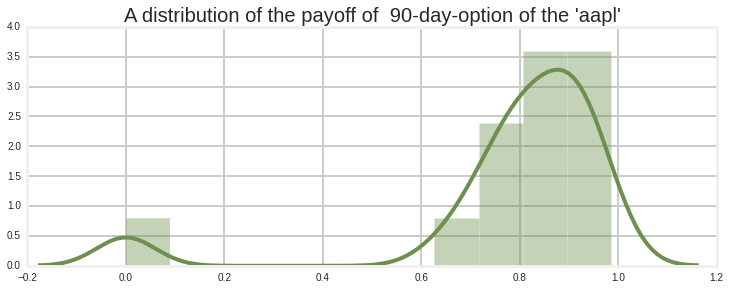

In [30]:
# Our MC estimator
def PayOffEstimator(paths,r,T,K):
    ''' returns Payoff estimation'''
    
    #N_Sim = paths.shape[1]
    #profit_trials=np.where(paths[-1,:]>=K)
    #zero_trials=np.where(paths[-1,:]<K)
    payoffs=np.maximum(paths[-1,:]-K,0.)
    return payoffs*np.exp(-r*T),np.average(payoffs)*np.exp(-r*T)

payoffs,avg_payoff=PayOffEstimator(paths,r,T,K)

print "On average, we earn about %.4f$ if we are buying %d-day-option (100 shares) of the '%s' now"%(avg_payoff*100,until_days,ticker)
zero_trials=np.where(payoffs==0)[0]
zero_trials_pct=float(len(zero_trials))/len(payoffs)*100.
print "Percentage of the zero-trials: %.2f%%"%zero_trials_pct
import seaborn as sns
#hist(payoffs) # get a r3 distributions (3rd step of the monte carlo simulation)

selection=np.where(payoffs<1.0)[0]
sns.distplot(payoffs[selection])
#sns.distplot(payoffs)
title("A distribution of the payoff of  %d-day-option of the '%s'"%(until_days,ticker))
#pd.Series(payoffs).plot()



It is important that your GBM model  of the $S(t)$ has a right estimation of the daily drift term $\mu$, which is determined by $r$ and $\sigma$,


\begin{eqnarray}\label{def:drift_term}
\mu =r−\frac{1}{2}\sigma^2.
\end{eqnarray}

$$\\[1pt]$$

What happens when we increase the free-risk rate $r$ in two times, and hence the daily trend term $\mu$ takes  a larger value?

The answer is given below.  

On average, we earn about 391.4910$ if we are buying 90-day-option (100 shares) of the 'aapl' now
Percentage of the zero-trials: 0.00%


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


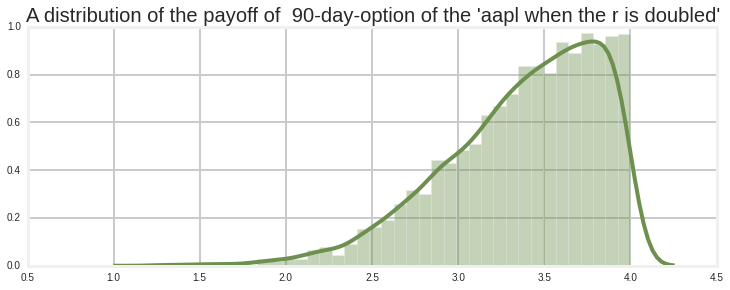

In [31]:
#we have artificially increased the drift term
r=0.0241 # a free-risk rate
r=2.0*r # let's double itb
stockprice_func = lambda dt,z: StockPriceGBM(r,sigma,dt,z)
paths=MonteCarloPriceGenerator(stockprice_func ,S_0=S_0,T=T,dt=dt,N_Sim=N_Sim)

payoffs,avg_payoff=PayOffEstimator(paths,r,T,K)

print "On average, we earn about %.4f$ if we are buying %d-day-option (100 shares) of the '%s' now"%(avg_payoff*100,until_days,ticker)
zero_trials=np.where(payoffs==0)[0]
zero_trials_pct=float(len(zero_trials))/len(payoffs)*100.
print "Percentage of the zero-trials: %.2f%%"%zero_trials_pct
import seaborn as sns
#hist(payoffs) # get a r3 distributions (3rd step of the monte carlo simulation)
selection=np.where(payoffs<4.0)[0]
sns.distplot(payoffs[selection])
#sns.distplot(payoffs)
title("A distribution of the payoff of  %d-day-option of the '%s when the r is doubled'"%(until_days,ticker))



$$\\[5pt]$$

## 1.6 Monte-Carlo Estimation of integrals

-------------------------------------------

$$\\[5pt]$$


In the end of my tutorial, I want to solve numerically  a few integrals presented in the assignment <a name="ref-11"/>[(CamDavidson-Pilon, 2012)](#cite-Assignment). 

Let's consider the exercise Nr. 2
>The next four questions deal with the problem of finding the integral
> $$I=\int_0^2e^{-x^2}dx$$
>Use both crude and antithetic random numbers to estimate the value of the integral.
>How large a sample size should be, for antithetic and random numbers, in order to estimate correctly I up to three decimal places with probability at least 95%?

$$\\[5pt]$$

### 1.6.1 Monte-Carlo Importance Sampling

-------------------------------------------
$$\\[5pt]$$

I will use a MC integrator proposed by Cam Davidson-Pilon, and slightly modified by me.
The technology of the importance sampling is very important in the world of the Monte Carlo integration. I'd like to refer a nice lecture <a name="ref-12"/>[(JessiCisewski, 2014)](#cite-ImportanceSampling) from Jessie Cisewski where you can find simple explanation of the technology.

In [32]:
# %load MCIntegrator.py
'''

 Taken from 
 https://github.com/CamDavidsonPilon/Python-Numerics/blob/master/MonteCarlo/Integration/MonteCarloIntegrator.py

 Author CamDavidsonPilon 
 Modified by Igor Marfin


'''

import numpy as np
import scipy.stats as stats
import time

class MCIntegrator( object ):
    """
    target_function: a function that accepts a n-D array, and returns an n-D array.
    interval: the interval of the integration
    b_antithetic: whether to use antithesis variables. Much quicker, but only useful on monotonic target_functions
    sampling_dist: a scipy frozen distribution with support equal to the interval
    N: number of variables to use in the initial estimate.
    control_variates = a list of function that accepts a nD array, and return an nD array
    """
    def __init__(self, target_function, 
                       interval = (0,1), 
                       N = 10000, 
                       b_antithetic = False, 
                       sampling_dist = stats.uniform(), 
                       verbose=False,
                       control_variates = []):
        self.target_function = target_function
        self.min_interval, self.max_interval = interval
        self.N_ = N
        self.N = 0
        self.sampling_dist = sampling_dist
        self.value =0
        self.var=np.nan
        self.b_antithetic = b_antithetic
        self.verbose = verbose
        self.control_variates = control_variates
        self.sample = np.array([])
   
   
    def estimate_N(self, N ):
        self.N += N
        return self._estimate(N)
        
        
        
    def _estimate(self, N):
        
        #generate N values from sampling_dist
        if not self.b_antithetic:
            U = self.sampling_dist.rvs(size=N)
            Y = self.target_function( U )
            for func in self.control_variates:
                X =  func(U)
                Y += X
                
            if self.verbose:
                print Y.var()
            self.value +=  Y.sum()
        else:
            U_ = self.sampling_dist.rvs(size=N/2)
            antiU_ = self.min_interval + (self.max_interval - U_ )
            Y =  (self.target_function( U_ ) + self.target_function( antiU_ ) )
            if self.verbose:
                print Y.var()
            self.value +=Y.sum()
        self.sample=np.concatenate((self.sample,Y))
        self.var = self.sample.var(ddof=1)
        return self.value / self.N 
        
    def estimate(self):
        self.N += self.N_
        return self._estimate(self.N_)


    def SE(self):        
        return np.sqrt(self.var/self.N) if self.var is not np.nan else np.nan



If we use uniform random numbers, we utilize a basic Monte-Carlo estimator to evaluate the value of the integral.

In [33]:
'''
  Monte Carlo estimation of the integral from the assignment
'''


import time
import scipy.stats as stats
def target(u):   
        return np.exp(-u**2)*2
    
mci = MCIntegrator( target, interval =(0,2), b_antithetic = False, sampling_dist = stats.uniform(0,2), verbose= True )
N = 1e6
    
start = time.clock()
print "Using %d samples,"%N
print "Non-antithetic: %.5f. (%.5f.)"%(mci.estimate_N(N ),mci.SE())
print "Duration: %.3f s."%(time.clock() - start) 
print 

/usr/local/lib/python2.7/dist-packages/scipy/stats/_continuous_distns.py:3909: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return mtrand.uniform(0.0, 1.0, self._size)
/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Using 1000000 samples,
0.475396645407
Non-antithetic: 0.88140. (0.00069.)
Duration: 0.140 s.



If we apply the sampling different from the uniform distribution in MC, i.e. we replace uniform distribution by some distribution close to the target function, then we can expect to increase the performance of the Monte Carlo.

In [34]:
'''
  Importance Sampling Monte Carlo estimation of the integral from the assignment  
'''
import math
def target(u,interval):   
        return ((u >= interval[0]) & (u <= interval[1]))*np.sqrt(math.pi)

targetPrime =  lambda u: target(u,(0,2))
mci = MCIntegrator( targetPrime, interval =(0,2), b_antithetic = False, sampling_dist = stats.norm(loc=0.,scale=1.), verbose= True )
N = 1e6
    
start = time.clock()
print "Using %d samples,"%N
print "Non-antithetic: %.5f. (%.5f.)"%(mci.estimate_N(N ),mci.SE())
print "Duration: %.3f s."%(time.clock() - start) 
print 

Using 1000000 samples,
0.783959574083
Non-antithetic: 0.84830. (0.00089.)
Duration: 0.130 s.



/usr/local/lib/python2.7/dist-packages/scipy/stats/_continuous_distns.py:127: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return mtrand.standard_normal(self._size)


The importance sampling improves the MC efficiency, i.e.  achieving high accuracy of the integration requires less computing time.

Let's check another importance sampling functions.

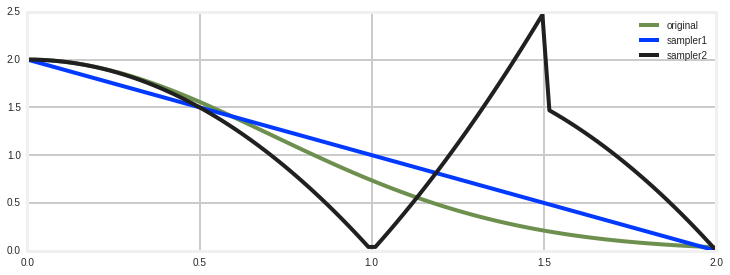

In [35]:
x = np.linspace(0,2, 100)
def target(u):   
        return np.exp(-u**2)*2
def sampler1(u):
    ''' a linear approximation of the exponent tail '''
    return (-.5*u + 1)*2
def sampler2(u):
    '''
       Taylor Series Expansions of Exponential Functions  
       http://www.efunda.com/math/taylor_series/exponential.cfm
    '''
    #return (1-u**2+u**4/2.-u**6/2./3.+u**8/2./3./4.)*2
    a = np.array([ 0. if b<1. else round(b)-1 for b in u]) # a regularization term
    return np.abs(1.-(u-a)**2)*2
    
    
plot(x,target(x),label="original")
plot(x,sampler1(x),label="sampler1")
plot(x,sampler2(x),label="sampler2")
legend(loc="upper right")


$$\\[5pt]$$

#### 1.6.1.1 Reject/Accept method for the Monte-Carlo Importance Sampling

--------------------------------------------------------------------
$$\\[5pt]$$

The code, shown below, is a simple Reject/Accept method to generate samples according some analytical functions.

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Sampler1
Using 1000000 samples,
0.21254036049
Non-antithetic: 0.88171. (0.00046.)
Duration: 0.170 s.

Sampler2
Using 1000000 samples,
5.44010673961
Non-antithetic: 0.82234. (0.00233.)
Duration: 2.520 s.



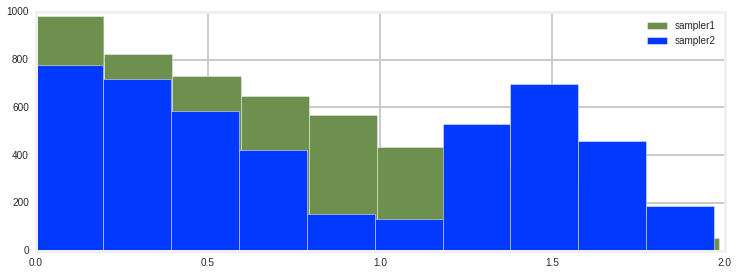

In [37]:
'''
    A realization of the importance sampler for any sampling distribution
    See http://people.duke.edu/~ccc14/sta-663/MonteCarlo.html
'''

import scipy.stats as st

# Reject/Accept method to generate samples according the target function
class Importance(object):
    def __init__(self,target,interval):
        self.target = target
        self.interval = interval
    
    def rvs(self,size):
        u = np.random.uniform(*self.interval,size=size)        
        # accept-reject criterion for each point in sampling distribution
        # what is the best interval of the randomly generated numbers?
        # this one ?
        r = np.random.uniform(np.min(self.target(u)), np.max(self.target(u)), size)
        # or this one?
        #r = np.random.uniform(0, np.max(self.target(u)), size)
        # or this one?
        #r = np.random.uniform(*self.interval, size=size)
        # accepted points will come from target distribution
        v = u[r <= self.target(u)]
        return v



# An alternative approach. 
# This calculator is technically hard to control: rv_continuous can produce
# negative values of the pdf.

#class Importance(st.rv_continuous):
#    def _pdf(self,x):
#        pass
#Importance._pdf = lambda self,x: sampler1(x)
#mysampler = Importance(name='mysampler')


interval =(0,2)    
x = np.linspace(*interval, num=100)

def target(u):   
    ''' a function to be integrated'''
    return np.exp(-u**2)*2



# An Example of the importance sampling with the Sampler1
mysampler1=Importance(sampler1,interval)
hist(mysampler1.rvs(10000),label="sampler1") # to plot distribution

# normalization of the sampler
normalization1=MCIntegrator(sampler1, interval=interval, b_antithetic = False, sampling_dist = stats.uniform(*interval)).estimate_N(1e6)

# target function should be modified accordingly!
def targetPrime(x,target,sampler,interval,normalization):
    return target(x)/(sampler(x)/(interval[1]-interval[0]))*normalization

_targetPrime = lambda x: targetPrime(x,target,sampler1,interval,normalization1)
mci = MCIntegrator(_targetPrime, interval =interval, b_antithetic = False, sampling_dist = mysampler1, verbose= True )
N = 1e6
    
start = time.clock()
print "Sampler1"
print "Using %d samples,"%N
print "Non-antithetic: %.5f. (%.5f.)"%(mci.estimate_N(N ),mci.SE())
print "Duration: %.3f s."%(time.clock() - start) 
print 


# An Example of the importance sampling with the Sampler2

mysampler2=Importance(sampler2,interval)
hist(mysampler2.rvs(10000),label="sampler2") # to plot distribution

# normalization of the sampler
normalization2=MCIntegrator(sampler2, interval=interval, b_antithetic = False, sampling_dist = stats.uniform(*interval)).estimate_N(1e6)
_targetPrime2 = lambda x: targetPrime(x,target,sampler2,interval,normalization2)

mci = MCIntegrator( _targetPrime2, interval =interval, b_antithetic = False, sampling_dist = mysampler2, verbose= True )
N = 1e6
    
start = time.clock()
print "Sampler2"
print "Using %d samples,"%N
print "Non-antithetic: %.5f. (%.5f.)"%(mci.estimate_N(N ),mci.SE())
print "Duration: %.3f s."%(time.clock() - start) 
print 


   
legend(loc="upper right")


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.881972798098
Original Target
Using 10000000 samples,
3.86541843558e-29
Non-antithetic: 0.75968. (0.00000.)
Duration: 3.480 s.



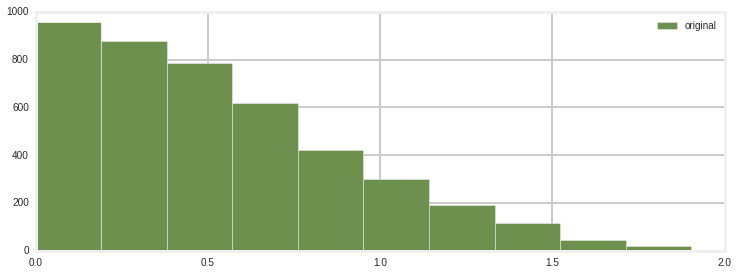

In [38]:
# An Example of the importance sampling with the original target

mysampler3=Importance(target,interval)
hist(mysampler3.rvs(10000),label="original") # to plot distribution

# normalization of the sampler
normalization3=MCIntegrator(target, interval=interval, b_antithetic = False, sampling_dist = stats.uniform(*interval)).estimate_N(1e6)
_targetPrime3 = lambda x: targetPrime(x,target,target,interval,normalization3)

print normalization3

mci = MCIntegrator( _targetPrime3, interval =interval, b_antithetic = False, sampling_dist = mysampler3, verbose= True )
N = 1e7
    
start = time.clock()
print "Original Target"
print "Using %d samples,"%N
print "Non-antithetic: %.5f. (%.5f.)"%(mci.estimate_N(N ),mci.SE())
print "Duration: %.3f s."%(time.clock() - start) 
print 


   
legend(loc="upper right")

As it was expected, different samplers give different results. The obtained results show that the simpler sampler is, the better performance can be achieved.


$$\\[5pt]$$

### 1.6.2 Monte-Carlo with Stratified Sampling

-------------------------------------------
$$\\[5pt]$$

Next our task is to implement the stratified sampling <a name="ref-13"/>[(WikiStratifiedSampling, 2016)](#cite-Stratified) in the Monte Carlo estimator. Why do we need to stratify sample at all? This can improve the accuracy of the Monte Carlo estimation. Let's integrate our target function in the 5 regions as $0\leq x\leq 0.5$, $0.5\leq x\leq 1.5$,$1.5\leq x\leq 2$, $0\leq x\leq 1$ and $1\leq x\leq 2$ using a basic MC. 



In [39]:
from operator import isub
import scipy.integrate as integrate

def target(u):   
        return np.exp(-u**2)*2
    

def validation_of_integration(target,interval,val):
    ''' compare results obtained by MC and  
        using a technique from the Fortran library QUADPACK.
    '''
    result_quad = integrate.quad(target, *interval)[0]
    print "QUADPACK: %.5f and MC: %r"%(result_quad,val[0])
    print "MC Error: %r"%(val[1])
    return val[0],result_quad

def MCEstimation(target, interval,N = 1e6):
    mci=MCIntegrator( target, interval =interval, b_antithetic = False, sampling_dist = stats.uniform(*interval), verbose= True )    
    return -mci.estimate_N(N )*isub(*interval),mci.SE()

# Integrate the target function in the 3 sub-regions
print "3 sub-regions"
intervals = [(0,0.5),(0.5,1.5),(1.5,2)]
integralMC=0
integralQUAD=0

for interval in intervals:
    print
    _tmp1,_tmp2=validation_of_integration(target,interval,MCEstimation(target,interval)) 
    integralMC+=_tmp1
    integralQUAD+=_tmp2    
    print
print "Result MC is ",integralMC
print "Result QUAD is ",integralQUAD

print
print "2 sub-regions"
intervals = [(0,1),(1,2)]
integralMC=0
integralQUAD=0

for interval in intervals:
    print
    _tmp1,_tmp2=validation_of_integration(target,interval,MCEstimation(target,interval)) 
    integralMC+=_tmp1
    integralQUAD+=_tmp2    
    print
print "Result MC is ",integralMC
print "Result QUAD is ",integralQUAD



print
print "1 region"
intervals = [(0,2)]
integralMC=0
integralQUAD=0


for interval in intervals:
    print
    _tmp1,_tmp2=validation_of_integration(target,interval,MCEstimation(target,interval)) 
    integralMC+=_tmp1
    integralQUAD+=_tmp2    
    print
print "Result MC is ",integralMC
print "Result QUAD is ",integralQUAD


3 sub-regions

0.018022824605
QUADPACK: 0.92256 and MC: 0.92266051398506843
MC Error: 0.00013424918110660584


0.215369406245
QUADPACK: 0.78981 and MC: 0.56114633640158273
MC Error: 0.00046407932685548262


0.00248147688842
QUADPACK: 0.05179 and MC: 0.015017947367964572
MC Error: 4.9814449408738103e-05

Result MC is  1.49882479775
Result QUAD is  1.76416278152

2 sub-regions

0.161585774809
QUADPACK: 1.49365 and MC: 1.4939922544849218
MC Error: 0.00040197753220198699


0.0377347962115
QUADPACK: 0.27051 and MC: 0.1397071083441512
MC Error: 0.00019425455965400439

Result MC is  1.63369936283
Result QUAD is  1.76416278152

1 region

0.474715539751
QUADPACK: 1.76416 and MC: 1.7633504652270953
MC Error: 0.00068899638204205304

Result MC is  1.76335046523
Result QUAD is  1.76416278152


It is clearly visible that Monte Carlo is inaccurate in the region of $0.5\leq x\leq 1.5$. We could perhaps increase the MC accuracy if more points were generated in this region.
Let's try to stratify the sample. I have found a simple code, ``stratified.py``, for this purpose.

In [169]:
!wget https://gist.githubusercontent.com/spacelis/6088623/raw/1c71eeb3ab0548e33bae99afacaacd9963438664/stratified.py

--2016-04-13 16:54:41--  https://gist.githubusercontent.com/spacelis/6088623/raw/1c71eeb3ab0548e33bae99afacaacd9963438664/stratified.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 23.235.43.133
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|23.235.43.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2186 (2.1K) [text/plain]
Saving to: `stratified.py'

100%[======================================>] 2,186       --.-K/s   in 0s      

2016-04-13 16:54:43 (31.3 MB/s) - `stratified.py' saved [2186/2186]



In [51]:
# %load stratified.py
#!/usr/bin/env python
"""
File: stratified.py
Author: SpaceLis
Email: Wen.Li@tudelft.nl
Github: http://github.com/spacelis
Description:
    Sampling in a stratified way. That is sampling from each subpopulation to
    make the sample set more representative than simple random sampling. For
    example, a population of places from each category is not uniform, it is
    needed to insure each category has a place sampled and the number of the
    samples from each category should be propotional to its size.
"""


import numpy as np
from itertools import tee, izip, chain
from collections import Counter


def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return izip(a, b)


def int_partition(K, percentages, minimum=1):
    """ Scale the percentages up K times
    """
    assert K > minimum * len(percentages), 'K is too small for partitioning'
    p = np.array(percentages, dtype=np.float)
    dist = np.ones(len(p), dtype=np.float) * minimum
    dist += (K - len(p)) * p
    left = K - dist.sum()
    if left > 0:
        while left > 0:
            diff = p * K - dist
            dist[np.argmax(diff)] += 1
            left -= 1
    elif left < 0:   # FIXME seems never having chance to run actually
        while left < 0:
            diff = p * K - dist
            dist[np.argmin(diff)] -= 1
            left += 1
    return dist


def stratified_samples(iterable, percentages, size, prop_sizes=True,replace=False):
    """ Sampling the data with stratified sampling
    """
    partitions = len(percentages)
    dist = sorted(Counter(iterable).iteritems(),
                  key=lambda x: x[1],
                  reverse=True)
    if prop_sizes:
        samplesize = int_partition(float(size), percentages)
    else:
        samplesize = int_partition(size,
                                   [1. / partitions] * partitions)
    pivots = list(np.cumsum(int_partition(len(dist), percentages)))
    chozen_idx = [np.random.choice(range(int(s), int(t)), n, replace=replace)
            for n, (s, t) in zip(samplesize, pairwise([0] + pivots))]
    chozen = [[dist[i][0] for i in ig] for ig in chozen_idx]
    return chozen

In [54]:
'''
    Stratified Sampling
    Igor Marfin @2014 <Unister Gmbh>
'''
interval=(0,2)
intervals = [(0,0.5),(0.5,1.5),(1.5,2)]
x=stats.uniform(*interval).rvs(10000)
subsamples=[]
func_vals=[]
for interval in intervals:
    condition = (x>=interval[0]) & (x<=interval[1])    
    subsamples+=[x[condition].tolist()]
    func_vals+=[target(x[condition]).tolist()]
    #func_vals+=target(x[condition]).tolist()

import itertools
import operator
subsamplesmerged=list(itertools.chain.from_iterable([zip(b,a) for a,b in zip(subsamples,func_vals)]))
a=stratified_samples(subsamplesmerged,[0.8,0.1,0.1],1000)
for i,item in enumerate(a):
    print "Average in %d region is %f"%(i,np.average(np.array(map(operator.itemgetter(0),item))))


Average in 0 region is 0.863028
Average in 1 region is 0.874898
Average in 2 region is 0.813675


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:64: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


and it is obvious that it only  works for categorical values and not numbers.

$$\\[5pt]$$

#### 1.6.2.1 The adaptive Monte Carlo VEGAS algorithm

-------------------------------------------
$$\\[5pt]$$


There is a method implementing the adaptive stratified sampling for Monte Carlo 
simulations. This method is called VEGAS algorithm. You can install python version of the VEGAS algorithm <a name="ref-14"/>[(G.P.Lepage, 2015)](#cite-VEGAS).

In [221]:
!sudo pip install vegas

[sudo] password for debian: 



If we repeat the MC integration of the target function with VEGAS, we can build the adaptive grid of the stratified sampling used in this MC. The example below shows that adaptive stratified sampling improves Monte-Carlo estimation dramatically.

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.789791(70)    0.789791(70)        0.00     1.00
  2   0.789910(65)    0.789855(48)        1.55     0.21
  3   0.789973(66)    0.789895(39)        1.82     0.16
  4   0.789858(68)    0.789886(34)        1.29     0.28
  5   0.789829(72)    0.789876(30)        1.10     0.35

QUADPACK: 0.78981 and MC: RAvgArray([0.789876(30)], dtype=object)
MC Error: 0.35462157595551524


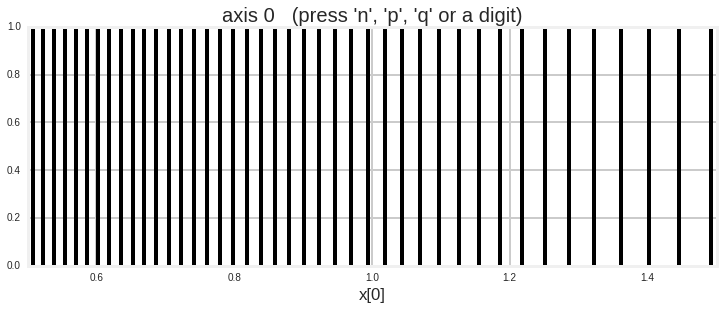

In [62]:
'''
    An example of the application of the VEGAS algorithm
'''
import vegas

# a problematic interval
interval = (0.5,1.5)
def target(u):   
        return np.exp(-u**2)*2

integ = vegas.Integrator([interval])
result = integ(target, nitn=5, neval=1000)
print(result.summary())
#print('result = %s    Q = %.2f' % (result, result.Q))
validation_of_integration(target,interval,(result, result.Q)) 

# show the adaptive grid
integ.map.show_grid(40)

That's it for this lecture.

$$\\[5pt]$$

# 2. Plans for  next tutorials

-------------------------------------------
$$\\[5pt]$$

A short ```to-do`` list for my future lectures is the following:

* Introduction to Strategies of the option trading like

  * ``Covered Call``
  * ``Protective Put``
  * ``Option Strangle``
  * ``Butterfly spread``
  * etc

* Developing the self-learned machinery to make decisions following some option strategy 
* Miscellaneous

In [198]:
### Do not delete the following Markdown section! 
### This is the BibTeX references!

<!--bibtex


@Article{Assignment,
  Author    = {Cam Davidson-Pilon,},
  Title     = {STAT906 - Assignemtn Nr.3}, 
  year      = 2012,
  url       = "https://github.com/CamDavidsonPilon/Python-Numerics/blob/master/MonteCarlo/Integration/Assignment.pdf",  
}

@Article{wiki,
  Author    = {Wiki:SDE,},
  Title     = {Stochastic differential equation}, 
  year      = 2016,
  url       = "https://en.wikipedia.org/wiki/Stochastic_differential_equation",  
}
@Article{ITO,
  Author    = {Wiki:Ito_Lemmma,},
  Title     = {Itô's lemma}, 
  year      = 2016,
  url       = "https://en.wikipedia.org/wiki/It%C3%B4's_lemma",  
}

@Article{Option,
  Author    = {Wiki:option,},
  Title     = {Call Option}, 
  year      = 2016,
  url       = "https://en.wikipedia.org/wiki/Call_option",  
}
@Article{NumericalSchemes,
  Author    = {Jan Palcyewski,},
  Title     = {Lecture5: Numerical schemes for SDEs}, 
  year      = 2016,
  url       = "http://www.mimuw.edu.pl/~apalczew/CFP_lecture5.pdf",  
}
@Article{BidAskSpread,
  Author    = {Investopedia,},
  Title     = {The Basics Of The Bid-Ask Spread}, 
  year      = 2016,
  url       = "http://www.investopedia.com/articles/trading/121701.asp",  
}
@Article{WikiVolatility,
  Author    = {WikiVolatility,},
  Title     = {Volatility in finance}, 
  year      = 2016,
  url       = "https://en.wikipedia.org/wiki/Volatility_%28finance%29",
}

@Article{WikiBS,
  Author    = {Wiki Black–Scholes formula,},
  Title     = {Black–Scholes formula}, 
  year      = 2016,
  url       = "https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model",  
}

@Article{ImportanceSampling,
  Author    = {Jessi Cisewski,},
  Title     = {Importance Sampling}, 
  year      = 2014,
  url       = "http://astrostatistics.psu.edu/su14/lectures/cisewski_is.pdf",  
}

@Article{Stratified,
  Author    = {Wiki Stratified Sampling,},
  Title     = {Stratified Sampling}, 
  year      = 2016,
  url       = "https://en.wikipedia.org/wiki/Stratified_sampling",  
}

@Article{VEGAS,
  Author    = {G.P.Lepage,},
  Title     = {Adaptive Monte Carlo vegas algorithm}, 
  year      = 2015,
  url       = "https://pypi.python.org/pypi/vegas",  
}


-->

#References

<a name="cite-Assignment"/><sup>[^](#ref-1) [^](#ref-5) [^](#ref-11) </sup>Cam Davidson-Pilon,. 2012. _STAT906 - Assignemtn Nr.3_. [URL](https://github.com/CamDavidsonPilon/Python-Numerics/blob/master/MonteCarlo/Integration/Assignment.pdf)

<a name="cite-Wiki"/><sup>[^](#ref-2) </sup>Wiki:SDE,. 2016. _Stochastic differential equation_. [URL](https://en.wikipedia.org/wiki/Stochastic_differential_equation)

<a name="cite-ITO"/><sup>[^](#ref-3) </sup>Wiki:Ito_Lemmma,. 2016. _Itô's lemma_. [URL](https://en.wikipedia.org/wiki/It%C3%B4's_lemma)

<a name="cite-Option"/><sup>[^](#ref-4) [^](#ref-7) </sup>Wiki:option,. 2016. _Call Option_. [URL](https://en.wikipedia.org/wiki/Call_option)

<a name="cite-NumericalSchemes"/><sup>[^](#ref-6) </sup>Jan Palcyewski,. 2016. _Lecture5: Numerical schemes for SDEs_. [URL](http://www.mimuw.edu.pl/~apalczew/CFP_lecture5.pdf)

<a name="cite-BidAskSpread"/><sup>[^](#ref-8) </sup>Investopedia,. 2016. _The Basics Of The Bid-Ask Spread_. [URL](http://www.investopedia.com/articles/trading/121701.asp)

<a name="cite-WikiVolatility"/><sup>[^](#ref-9) </sup>WikiVolatility,. 2016. _Volatility in finance_. [URL](https://en.wikipedia.org/wiki/Volatility_%28finance%29)

<a name="cite-WikiBS"/><sup>[^](#ref-10) </sup>Wiki Black–Scholes formula,. 2016. _Black–Scholes formula_. [URL](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model)

<a name="cite-ImportanceSampling"/><sup>[^](#ref-12) </sup>Jessi Cisewski,. 2014. _Importance Sampling_. [URL](http://astrostatistics.psu.edu/su14/lectures/cisewski_is.pdf)

<a name="cite-Stratified"/><sup>[^](#ref-13) </sup>Wiki Stratified Sampling,. 2016. _Stratified Sampling_. [URL](https://en.wikipedia.org/wiki/Stratified_sampling)

<a name="cite-VEGAS"/><sup>[^](#ref-14) </sup>G.P.Lepage,. 2015. _Adaptive Monte Carlo vegas algorithm_. [URL](https://pypi.python.org/pypi/vegas)

